# Scraping houses prices

In [18]:
import glob
import math
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup

### Sold date 
This is the HTML structure of the sold date element:
```html
<span class="hcl-label hcl-label--state hcl-label--sold-at">
    Såld 9 oktober 2023
</span>
```
The following function extracts the sold date from the list item:

In [19]:
swedish_to_english_months = {
	'januari': 'January', 'februari': 'February', 'mars': 'March',
	'april': 'April', 'maj': 'May', 'juni': 'June',
	'juli': 'July', 'augusti': 'August', 'september': 'September',
	'oktober': 'October', 'november': 'November', 'december': 'December'
}


def extract_sold_date(li):
	sold_date_element = li.find("span", class_="hcl-label hcl-label--state hcl-label--sold-at")
	if sold_date_element is not None:
		sold_date = (
			sold_date_element.text
			.replace("Såld ", "")
			.strip()
		)
		for swedish_month, english_month in swedish_to_english_months.items():
			sold_date = sold_date.replace(swedish_month, english_month)
		sold_date = datetime.strptime(sold_date, '%d %B %Y')
		return sold_date
	return None

### Address
This is the HTML structure of the address element:
```html
<h2 class="sold-property-listing__heading qa-selling-price-title hcl-card__title">
  Skårby station 350
</h2>
```
The following function extracts the address from the list item:

In [20]:
def extract_address(li):
	address_element = li.find("h2", class_="sold-property-listing__heading qa-selling-price-title hcl-card__title")
	if address_element is not None:
		address = (
			address_element.text
			.strip()
		)
		return address
	return None

### Location of the estate
This is the HTML structure of the location element:
```html
   <div class="sold-property-listing__location">
	 <div>
	   <span class="property-icon property-icon--result">...</span>
	   Kareby,
	   Kungälvs kommun
	 </div>
   </div>
```
The following function extracts the location from the list item:

In [21]:
def extract_location(li):
	location_element = li.find("div", class_="sold-property-listing__location").div
	if location_element is not None:
		location_element.find("span").decompose()
		location = re.sub(
			r'\n\s+',
			" ",
			location_element.text.strip(),
		)
		return location
	return None

### Area of the house & number of rooms
This is the HTML structure of the info element:
```html
<div class="sold-property-listing__subheading sold-property-listing__area">
	143
	<span class="listing-card__attribute--normal-weight">
		+ 25&nbsp;m²
	</span>
	&nbsp;
	7&nbsp;rum
</div>
```
or
```html
<div class="sold-property-listing__subheading sold-property-listing__area">
	123&nbsp;m²
	&nbsp;
	6&nbsp;rum
</div>
```
The following function extracts the area of the house and the number of rooms from the list item:

In [22]:
def extract_info(li):
	info_element = li.find("div", class_="sold-property-listing__subheading sold-property-listing__area")
	if info_element is not None:
		if info_element.find("span") is not None:
			biarea = float(
				info_element
				.find("span").text
				.replace("\u00a0", "")
				.replace("m²", "")
				.replace("+ ", "")
				.replace(",", ".")
				.strip()
			)
			info_element.find("span").decompose()
		else:
			biarea = None
		values = (
			info_element.text
			.replace("\u00a0m²", "")
			.replace("\u00a0rum", "")
			.split("\u00a0")
		)
		values = [
			float(v.replace(",", ".").strip())
			for v in values
			if re.match(
				r'^-?\d+(?:\.\d+)?$',
				v.replace(",", ".").strip()
			) is not None
		]
		boarea, rooms = (values + [None, None])[:2]
		rooms = int(rooms) if rooms is not None else None

		if boarea is not None and biarea is not None:
			total_area = boarea + biarea
		else:
			total_area = None

		return boarea, biarea, rooms, total_area
	return None, None, None, None

### Area of the plot
This is the HTML structure of the plot area element:
```html
<div class="sold-property-listing__land-area">
	2&nbsp;963&nbsp;m² tomt
</div>
```
The following function extracts the plot area from the list item:

In [23]:
def extract_plot_area(li):
	plot_element = li.find("div", class_="sold-property-listing__land-area")
	if plot_element is not None:
		plot_area = float(
			plot_element.text
			.replace("\u00a0", "")
			.replace("m² tomt", "")
			.replace(",", ".")
			.strip()
		)
		return plot_area
	return None

### Closing price
This is the HTML structure of the price element:
```html
<span class="hcl-text hcl-text--medium">
	Slutpris 4&nbsp;395&nbsp;000&nbsp;kr
</span>
```
The following function extracts the closing price from the list item:

In [24]:
def extract_price(li):
	price_element = li.find("span", class_="hcl-text hcl-text--medium")
	if price_element is not None:
		price = float(
			price_element.text
			.replace("\u00a0", "")
			.replace("Slutpris ", "")
			.replace("kr", "")
			.replace(",", ".")
			.strip()
		)
		return price
	return None

### Processing a list element
The following function processes a list element and extracts all the required information:

In [25]:
def process_list_element(li):
	sold_date = extract_sold_date(li)
	address = extract_address(li)
	location = extract_location(li)
	boarea, biarea, rooms, total_area = extract_info(li)
	plot_area = extract_plot_area(li)
	price = extract_price(li)
	return {
		"sold_date": sold_date,
		"address": address,
		"location": location,
		"boarea": boarea,
		"biarea": biarea,
		"total_area": total_area,
		"room_number": rooms,
		"plot_area": plot_area,
		"closing_price": price,
	}

### Processing all the pages
The following code processes all the pages and extracts the required information:

In [26]:
data_list = []
file_pattern = "data/kungalv_slutpris_page_*.html"
for file_name in glob.glob(file_pattern):
	with open(file_name, "r") as f:
		content = f.read()
		soup = BeautifulSoup(content, "html.parser")
		print("Processing", file_name, "...")
		data_list.extend(map(
			process_list_element,
			soup.find_all("li", class_="sold-results__normal-hit")
		))

Processing data/kungalv_slutpris_page_27.html ...
Processing data/kungalv_slutpris_page_31.html ...
Processing data/kungalv_slutpris_page_11.html ...
Processing data/kungalv_slutpris_page_07.html ...
Processing data/kungalv_slutpris_page_06.html ...
Processing data/kungalv_slutpris_page_10.html ...
Processing data/kungalv_slutpris_page_30.html ...
Processing data/kungalv_slutpris_page_26.html ...
Processing data/kungalv_slutpris_page_40.html ...
Processing data/kungalv_slutpris_page_17.html ...
Processing data/kungalv_slutpris_page_01.html ...
Processing data/kungalv_slutpris_page_21.html ...
Processing data/kungalv_slutpris_page_37.html ...
Processing data/kungalv_slutpris_page_36.html ...
Processing data/kungalv_slutpris_page_20.html ...
Processing data/kungalv_slutpris_page_16.html ...
Processing data/kungalv_slutpris_page_39.html ...
Processing data/kungalv_slutpris_page_03.html ...
Processing data/kungalv_slutpris_page_15.html ...
Processing data/kungalv_slutpris_page_35.html ...


### Saving the data
The following code saves the extracted data to a CSV file:

In [27]:
df = pd.DataFrame(data_list)
df["sold_date"] = pd.to_datetime(df["sold_date"])

df.to_csv("data/housing_data.csv", index=False)

# Analyzing 2022 house sales

### Filtering only the 2022 sales
The following code filters the pandas DataFrame to only include the sales from 2022:

In [28]:
df = df[df["sold_date"].dt.year == 2022]
df.describe()

,sold_date,boarea,biarea,total_area,room_number,plot_area,closing_price
count,190,190.000000,93.000000,93.000000,178.000000,184.000000,1.900000e+02
mean,2022-06-14 22:36:37.894736896,121.326316,53.849462,181.204301,4.943820,1806.826087,5.076153e+06
min,2022-01-07 00:00:00,4.000000,2.000000,65.000000,2.000000,127.000000,1.650000e+06
25%,2022-03-30 00:00:00,97.250000,21.000000,140.000000,4.000000,600.750000,4.012500e+06
50%,2022-06-07 00:00:00,120.000000,48.000000,174.000000,5.000000,1118.500000,5.000000e+06
75%,2022-08-31 18:00:00,144.750000,75.000000,211.000000,6.000000,1718.500000,5.795000e+06
max,2022-12-27 00:00:00,325.000000,174.000000,406.000000,10.000000,47500.000000,1.050000e+07
std,NaN,45.168454,37.700175,62.483660,1.413091,4108.109618,1.557399e+06


### Plotting the distribution of the closing prices
The following code extracts the closing prices and plots the distribution using a boxplot and a histogram.

For the histogram, the number of bins is calculated using the square root rule.

In [29]:
closing_price_list = df["closing_price"].dropna().tolist()

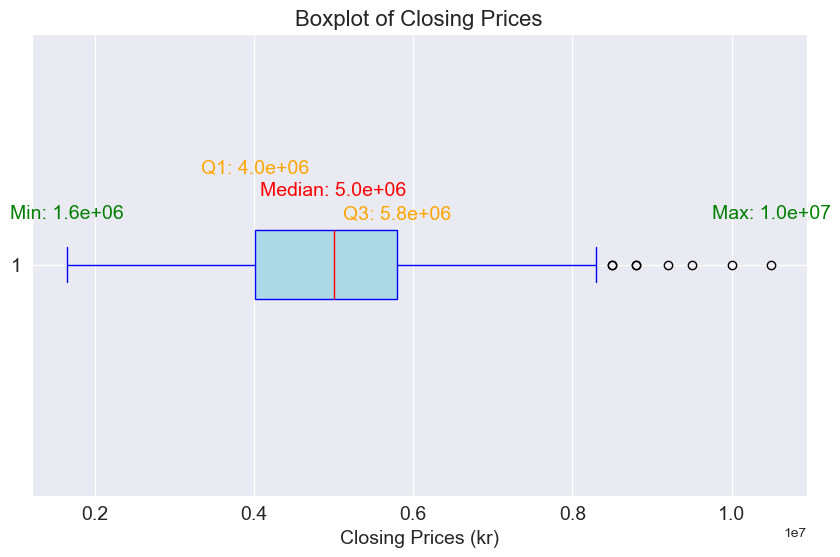

In [30]:
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(
	closing_price_list,
	vert=False,
	patch_artist=True,
	boxprops=dict(facecolor='lightblue', color='blue'),
	whiskerprops=dict(color='blue'),
	capprops=dict(color='blue'),
	medianprops=dict(color='red'),
)

# Calculate the five-number summary
minimum = np.min(closing_price_list)
maximum = np.max(closing_price_list)
median = np.median(closing_price_list)
q1 = np.percentile(closing_price_list, 25)
q3 = np.percentile(closing_price_list, 75)

# Annotate the five-number summary values
plt.text(minimum, 1.1, f'Min: {minimum:.1e}', horizontalalignment='center', color='green', fontsize = 14)
plt.text(q1, 1.2, f'Q1: {q1:.1e}', horizontalalignment='center', color='orange', fontsize = 14)
plt.text(median, 1.15, f'Median: {median:.1e}', horizontalalignment='center', color='red', fontsize = 14)
plt.text(q3, 1.1, f'Q3: {q3:.1e}', horizontalalignment='center', color='orange', fontsize = 14)
plt.text(maximum, 1.1, f'Max: {maximum:.1e}', horizontalalignment='center', color='green', fontsize = 14)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.title("Boxplot of Closing Prices", fontsize = 16)
plt.xlabel("Closing Prices (kr)", fontsize = 14)

plt.savefig("closing_prices_boxplot.png")

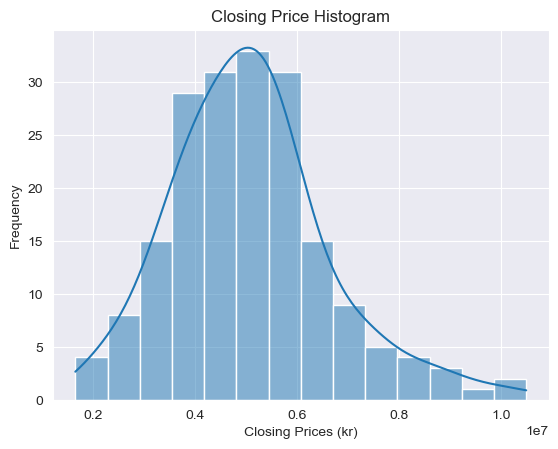

In [31]:
sns.histplot(closing_price_list, kde=True, bins=math.ceil(len(closing_price_list) ** 0.5))
plt.title("Closing Price Histogram")
plt.xlabel("Closing Prices (kr)")
plt.ylabel("Frequency")

plt.savefig("closing_prices_histogram.png")

### Plotting the relationship between the closing prices, living area and the number of rooms
The following code plots the relationship between the three variables using a scatter plot, first without the number of rooms and then with the number of rooms as a hue:

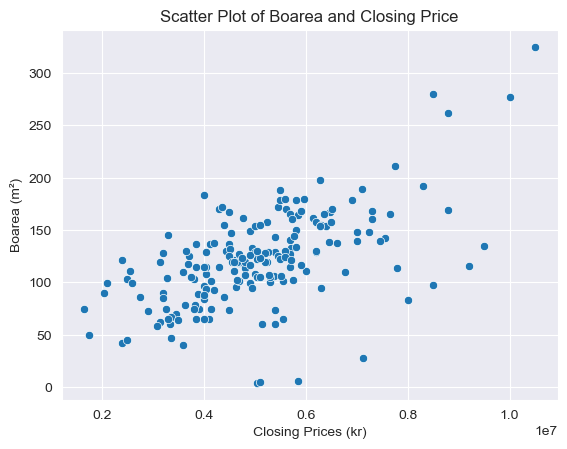

In [32]:
sns.scatterplot(x="closing_price", y="boarea", data=df)
plt.title("Scatter Plot of Boarea and Closing Price")
plt.xlabel("Closing Prices (kr)")
plt.ylabel("Boarea (m\u00B2)")

plt.savefig("closing_prices_boarea_scatter.png")

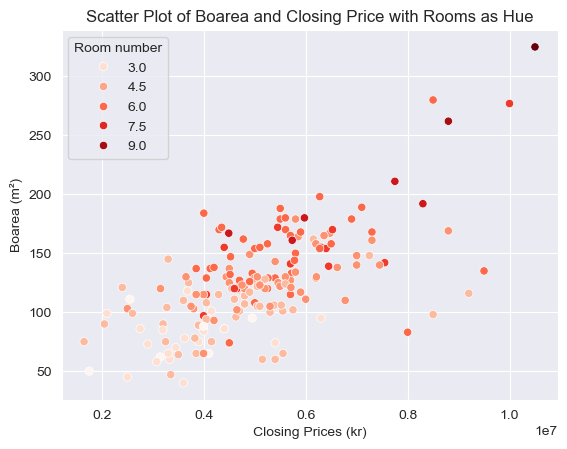

In [33]:
sns.scatterplot(x="closing_price", y="boarea", hue="room_number", data=df, palette="Reds")
plt.title("Scatter Plot of Boarea and Closing Price with Rooms as Hue")
plt.xlabel("Closing Prices (kr)")
plt.ylabel("Boarea (m\u00B2)")
plt.legend(title="Room number")

plt.savefig("closing_prices_boarea_rooms_scatter.png")